In [288]:
import wellmap
import pandas as pd
import os
import string
import seaborn as sns
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

New for multiple images in CP file

In [203]:
part_to_folder = r"C:\Users\Modern\Documents\Biorad\CellProfiler\Results\2024-07-25 Test plate"

# files = [f for f in listdir(part_to_folder) if isfile(join(part_to_folder, f))]

image_list_path = os.path.join(part_to_folder, "ExpImage.csv")
data_path  = os.path.join(part_to_folder, "ExpWells_plate.csv")

data_raw_df = pd.read_csv(data_path) 
image_list_df = pd.read_csv(image_list_path) 

print(image_list_df)


                                 FileName_RGB  ImageNumber
0  2024-07-25 Test plate 1 (Multichannel).tif            1
1  2024-07-25 Test plate 2 (Multichannel).tif            2
2  2024-07-25 Test plate 3 (Multichannel).tif            3


Extract wellmaps and combine into one df with names of the images

C:\Users\Modern\Documents\Biorad\CellProfiler\Results\2024-07-25 Test plate\2024-07-25 Test plate 1 (Multichannel).toml


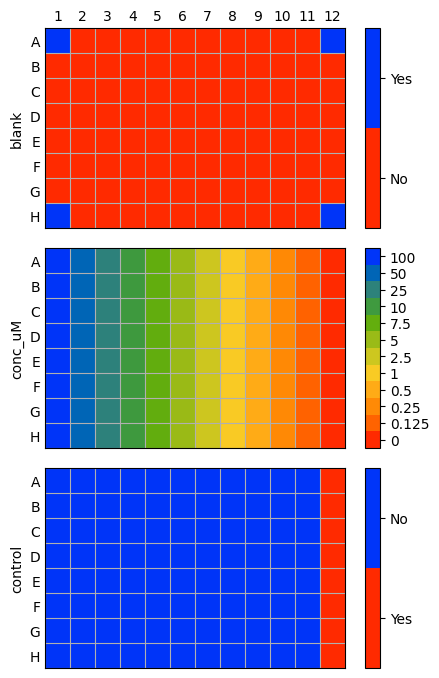

In [204]:
wellmap_path_list = []

for file in os.listdir(part_to_folder):
    if file.endswith(".toml"):
        wellmap_path_list.append(os.path.join(part_to_folder, file))
        # wellmap_path_list.append(file)

print(wellmap_path_list[0])

wellmap_df = wellmap.load(wellmap_path_list[0]) 

wellmap_list = []

for file in wellmap_path_list:
    wellmap_i = wellmap.load(file)
    wellmap_list.append(wellmap_i)

wellmaps_df = pd.concat(wellmap_list, axis=0, ignore_index=True)
# print(wellmaps_df)

wellmap.show(file);
plt.show();

Generating labels for wells

In [205]:
# row_column_df = pd.DataFrame(columns=['row','col'])

row =  list(string.ascii_uppercase[0:8])
column = list(range(1,13))
plate = image_list_df['FileName_RGB'].to_list()

row_column_list = []


for p in plate:
    for c in column:
        for r in row:
            array_i = [r,c]
            row_column_list.append(array_i)

row_column_df = pd.DataFrame(row_column_list, columns = ['row', 'col']) 

print(row_column_df)

    row  col
0     A    1
1     B    1
2     C    1
3     D    1
4     E    1
..   ..  ...
283   D   12
284   E   12
285   F   12
286   G   12
287   H   12

[288 rows x 2 columns]


Add images names to data (thank you CellProfiler for convenience)

In [206]:
data_full_df =  pd.merge(data_raw_df, image_list_df, on='ImageNumber') #Data with image names (FileName_RGB)
data_indexed = pd.concat([row_column_df, data_full_df], axis=1, join='inner') #Data with image names (FileName_RGB) and cell indexes (row,col)

data_indexed['col']=data_indexed['col'].astype(str) #Otherwise everything will break

data_plate = pd.merge(data_indexed, wellmaps_df, on=['FileName_RGB','row','col']) #Data with image names (FileName_RGB), cell indexes and wellmap
data_plate[["conc_uM"]] = data_plate[["conc_uM"]].apply(pd.to_numeric)

print(data_plate.columns)

Index(['row', 'col', 'ImageNumber', 'ObjectNumber',
       'Intensity_IntegratedIntensity_OrigGreen',
       'Intensity_IntegratedIntensity_OrigRed',
       'Intensity_MeanIntensity_OrigGreen', 'Intensity_MeanIntensity_OrigRed',
       'Intensity_StdIntensity_OrigGreen', 'Intensity_StdIntensity_OrigRed',
       'FileName_RGB', 'well', 'well0', 'row_i', 'col_j', 'blank', 'conc_uM',
       'cells', 'uv', 'RZ_incubation', 'substance', 'substance_incubation',
       'culture_type', 'control'],
      dtype='object')


Blank and control calculation for each plate

In [211]:
blank_control_array = []

for p in plate:
    blank_p = data_plate[(data_plate['blank'] == 'Yes') & (data_plate['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigGreen'].mean()
    control_p = data_plate[(data_plate['control'] == 'Yes') & (data_plate['blank'] == 'No') & (data_plate['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigGreen'].mean()
    blank_std_p = data_plate[(data_plate['blank'] == 'Yes') & (data_plate['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigGreen'].std()
    control_std_p = data_plate[(data_plate['control'] == 'Yes') & (data_plate['blank'] == 'No') & (data_plate['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigGreen'].std()

    bc_array_i = [blank_p,control_p,blank_std_p, control_std_p,p]

    blank_control_array.append(bc_array_i)


blank_control_df = pd.DataFrame(blank_control_array, columns = ['blank_mean', 'control_mean', 'blank_std','control_std','FileName_RGB']) 

print(blank_control_df)




   blank_mean  control_mean  blank_std  control_std  \
0    0.007892      0.008806   0.000542     0.000239   
1    0.017565      0.021726   0.000686     0.000670   
2    0.017624      0.021453   0.000634     0.000783   

                                 FileName_RGB  
0  2024-07-25 Test plate 1 (Multichannel).tif  
1  2024-07-25 Test plate 2 (Multichannel).tif  
2  2024-07-25 Test plate 3 (Multichannel).tif  


Blank exclusion and relative values calculating

In [220]:
data_plate_wo_blank_wells = data_plate[data_plate.blank == 'No'].copy() #dataframe without blank

data_plate_with_mean_blank_control = pd.merge(data_plate_wo_blank_wells, blank_control_df, on=['FileName_RGB'])

data_plate_with_mean_blank_control['Green_blanked'] = data_plate_with_mean_blank_control['Intensity_MeanIntensity_OrigGreen'] - data_plate_with_mean_blank_control['blank_mean']
data_plate_with_mean_blank_control['Green_relative'] = data_plate_with_mean_blank_control['Green_blanked']/data_plate_with_mean_blank_control['control_mean']*100

Data selection

In [213]:
# data_selected = data_plate_with_mean_blank_control[(data_plate_with_mean_blank_control['cells'] == 'Vero') & 
#                                                    (data_plate_with_mean_blank_control['sample'] == 'CK')]

# data_selected = data_plate_with_mean_blank_control[(data_plate_with_mean_blank_control['substance'] == 'ISK-1')]
# data_selected = data_plate_with_mean_blank_control[(data_plate_with_mean_blank_control['cells'] == 'hTERT')]
data_selected = data_plate_with_mean_blank_control[(data_plate_with_mean_blank_control['substance'] == 'Test 3')]

# print(data_selected['Intensity_IntegratedIntensity_OrigRed'][(data_selected['control'] == 'Yes')])

Plotting


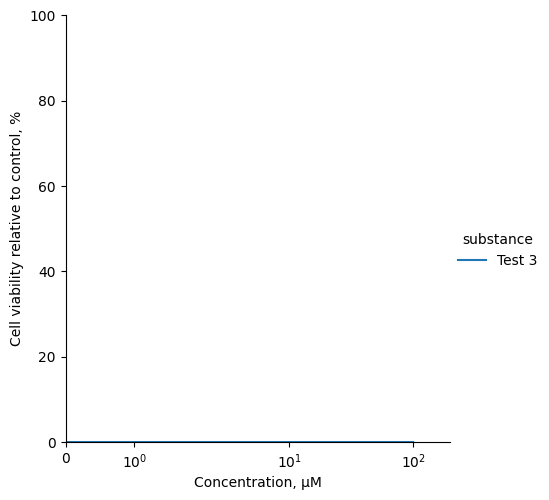

In [214]:
ax = sns.relplot(data=data_selected, x="conc_uM", y="Intensity_MeanIntensity_OrigGreen", kind="line", hue = 'substance')


# ax.set(xlabel=None, ylabel='Viable cell, % of control')

ax.set(xlabel='Concentration, μM', ylabel='Cell viability relative to control, %')
ax.set(xscale="symlog")

ax.set(xlim=(0, 200),ylim = (0,100))

plt.show()



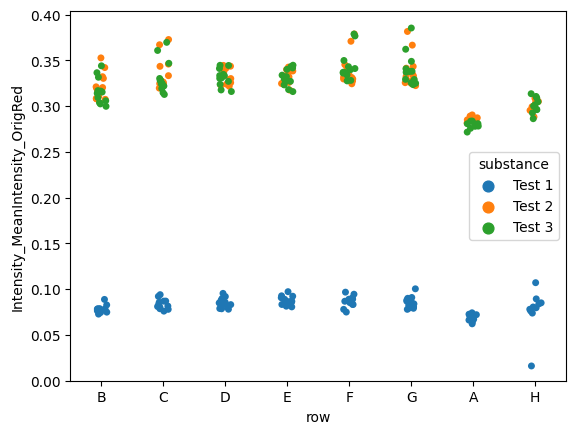

In [226]:
ax = sns.stripplot(data=data_plate_with_mean_blank_control, x="row", y="Intensity_MeanIntensity_OrigRed", hue = 'substance')
# ax.set(xscale="symlog")
# ax.set(xlim=(-1, 110))

ax.set(ylim = (0,None))
plt.show()


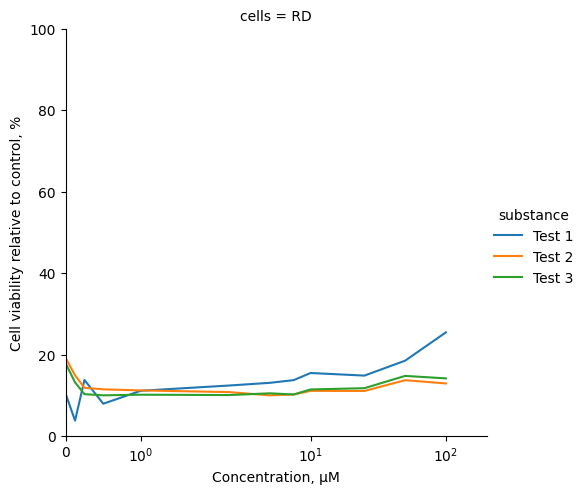

In [217]:
ax = sns.relplot(data=data_plate_with_mean_blank_control, x="conc_uM", y="Green_relative", kind="line", 
                 hue = 'substance', col='cells', ci=None)

ax.set(xlabel='Concentration, μM', ylabel='Cell viability relative to control, %')
ax.set(xscale="symlog")

ax.set(xlim=(0, 200),ylim = (0,100))

plt.show()

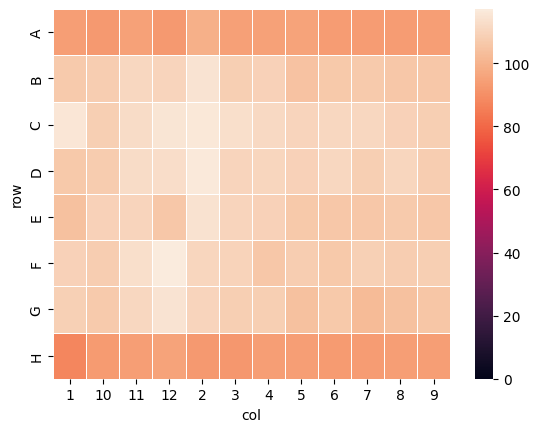

In [218]:
# ax = sns.heatmap(data=data_selected)
# ax.set(xscale="symlog")
# ax.set(xlim=(-1, 110))

# ax.set(ylim = (0,None))

data_selected = data_plate[(data_plate['substance'] == 'Test 3')].copy()

heatmap_df = data_selected.pivot(index="row", columns="col", values="Intensity_IntegratedIntensity_OrigGreen")

# print(heatmap_df)

sns.heatmap(heatmap_df, linewidth=.5, vmin=0, vmax=None)

plt.show()

In [227]:
row_drop_list = ['A','H']

data_plate_edges_drop = data_plate[~data_plate['row'].isin(row_drop_list)]



In [252]:
blank_control_array_ED = []

for p in plate:
    mean = data_plate_edges_drop[(data_plate_edges_drop['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigGreen'].mean()

    bc_array_i = [mean,p]

    blank_control_array_ED.append(bc_array_i)


blank_control_df_ED = pd.DataFrame(blank_control_array_ED, columns = ['mean','FileName_RGB']) 

print(blank_control_df_ED)

       mean                                FileName_RGB
0  0.009308  2024-07-25 Test plate 1 (Multichannel).tif
1  0.020829  2024-07-25 Test plate 2 (Multichannel).tif
2  0.020794  2024-07-25 Test plate 3 (Multichannel).tif


In [280]:
DPE_with_mean_blank_control = pd.merge(data_plate_edges_drop, blank_control_df_ED, on=['FileName_RGB'])

DPE_with_mean_blank_control['Mean_dif'] = DPE_with_mean_blank_control['Intensity_MeanIntensity_OrigGreen']/DPE_with_mean_blank_control['mean']

DPE_with_mean_blank_control['Mean_corr'] = DPE_with_mean_blank_control['Intensity_MeanIntensity_OrigGreen']/DPE_with_mean_blank_control['Mean_dif'] 

print(DPE_with_mean_blank_control['Mean_corr'])

0      0.009308
1      0.009308
2      0.009308
3      0.009308
4      0.009308
         ...   
211    0.020794
212    0.020794
213    0.020794
214    0.020794
215    0.020794
Name: Mean_corr, Length: 216, dtype: float64


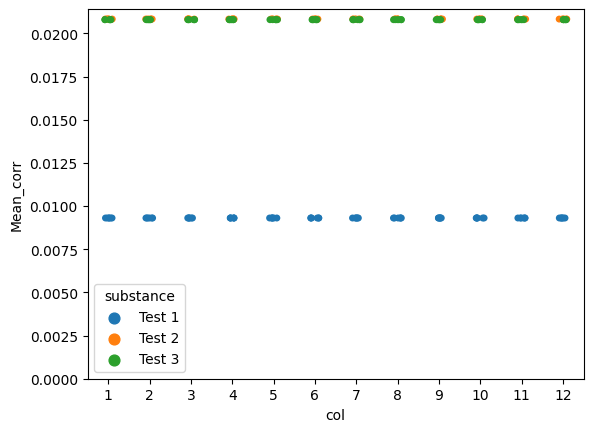

In [260]:
ax = sns.stripplot(data=DPE_with_mean_blank_control, x="col", y="Mean_corr", hue = 'substance')
# ax.set(xscale="symlog")
# ax.set(xlim=(-1, 110))

ax.set(ylim = (0,None))
plt.show()


In [262]:
path_to_folder_2 = r"C:\Users\Modern\Documents\Biorad\CellProfiler\Results\2024-07-24 Vero Rd hTERT CK-99c ISK-1 + CK-122 Slovesnova"

# files = [f for f in listdir(part_to_folder) if isfile(join(part_to_folder, f))]

image_list_path_2 = os.path.join(path_to_folder_2, "ExpImage.csv")
data_path_2  = os.path.join(path_to_folder_2, "ExpWells_plate.csv")

data_raw_df_2 = pd.read_csv(data_path_2) 
image_list_df_2 = pd.read_csv(image_list_path_2) 

print(image_list_df_2)


                                    FileName_RGB  ImageNumber
0     2024-07-19 RD CK-122 5H (Multichannel).tif            1
1   2024-07-19 Vero CK-122 5H (Multichannel).tif            2
2  2024-07-19 hTERT CK-122 5H (Multichannel).tif            3
3     2024-07-24 RD CK-99c 4H (Multichannel).tif            4
4      2024-07-24 RD ISK-1 4H (Multichannel).tif            5
5   2024-07-24 Vero CK-99c 4H (Multichannel).tif            6
6    2024-07-24 Vero ISK-1 4H (Multichannel).tif            7
7  2024-07-24 hTERT CK-99c 4H (Multichannel).tif            8
8   2024-07-24 hTERT ISK-1 4H (Multichannel).tif            9


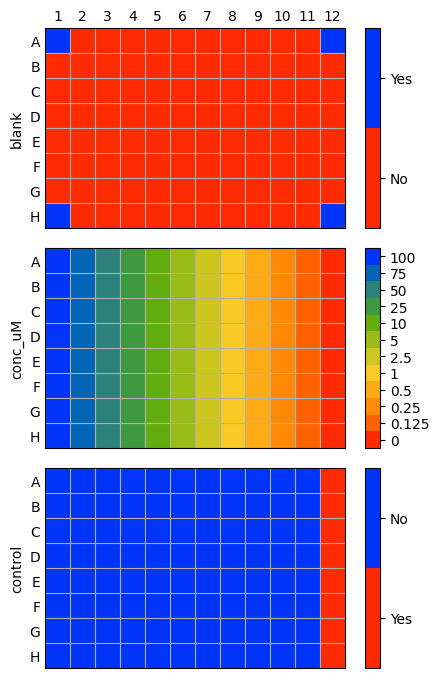

In [265]:
wellmap_path_list_2 = []

for file in os.listdir(path_to_folder_2):
    if file.endswith(".toml"):
        wellmap_path_list_2.append(os.path.join(path_to_folder_2, file))
        # wellmap_path_list.append(file)

# print(wellmap_path_list[0])

wellmap_df = wellmap.load(wellmap_path_list[0]) 

wellmap_list = []

for file in wellmap_path_list_2:
    wellmap_i = wellmap.load(file)
    wellmap_list.append(wellmap_i)

wellmaps_df_2 = pd.concat(wellmap_list, axis=0, ignore_index=True)
# print(wellmaps_df)

wellmap.show(file);
plt.show();

In [267]:
# row_column_df = pd.DataFrame(columns=['row','col'])

row =  list(string.ascii_uppercase[0:8])
column = list(range(1,13))
plate = image_list_df_2['FileName_RGB'].to_list()

row_column_list = []


for p in plate:
    for c in column:
        for r in row:
            array_i = [r,c]
            row_column_list.append(array_i)

row_column_df_2 = pd.DataFrame(row_column_list, columns = ['row', 'col']) 

print(row_column_df_2)

    row  col
0     A    1
1     B    1
2     C    1
3     D    1
4     E    1
..   ..  ...
859   D   12
860   E   12
861   F   12
862   G   12
863   H   12

[864 rows x 2 columns]


In [275]:
data_full_df_2 =  pd.merge(data_raw_df_2, image_list_df_2, on='ImageNumber') #Data with image names (FileName_RGB)
data_indexed_2 = pd.concat([row_column_df_2, data_full_df_2], axis=1, join='inner') #Data with image names (FileName_RGB) and cell indexes (row,col)

data_indexed_2['col']=data_indexed_2['col'].astype(str) #Otherwise everything will break

data_plate_2 = pd.merge(data_indexed_2, wellmaps_df_2, on=['FileName_RGB','row','col']) #Data with image names (FileName_RGB), cell indexes and wellmap
data_plate_2[["conc_uM"]] = data_plate_2[["conc_uM"]].apply(pd.to_numeric)

print(data_plate_2.columns)

Index(['row', 'col', 'ImageNumber', 'ObjectNumber',
       'Intensity_IntegratedIntensity_OrigGreen',
       'Intensity_IntegratedIntensity_OrigRed',
       'Intensity_MeanIntensity_OrigGreen', 'Intensity_MeanIntensity_OrigRed',
       'Intensity_StdIntensity_OrigGreen', 'Intensity_StdIntensity_OrigRed',
       'FileName_RGB', 'well', 'well0', 'row_i', 'col_j', 'blank', 'conc_uM',
       'cells', 'uv', 'RZ_incubation', 'substance', 'substance_incubation',
       'culture_type', 'control'],
      dtype='object')


In [285]:
data_extracted = data_plate_2[(data_plate_2['FileName_RGB'] == '2024-07-19 Vero CK-122 5H (Multichannel).tif')]

data_extracted['Mean_corr'] = data_extracted['Intensity_MeanIntensity_OrigGreen']/DPE_with_mean_blank_control['Mean_dif']

print(DPE_with_mean_blank_control['Mean_dif'])


#Надо попробовать сделать опорным 0_H планшет

0      1.015825
1      1.104357
2      1.112383
3      1.101387
4      1.087421
         ...   
211    1.054591
212    1.031884
213    0.969331
214    1.073561
215    1.051788
Name: Mean_dif, Length: 216, dtype: float64


C:\Users\Modern\AppData\Local\Temp\ipykernel_19420\2585179315.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_extracted['Mean_corr'] = data_extracted['Intensity_MeanIntensity_OrigGreen']/DPE_with_mean_blank_control['Mean_dif']


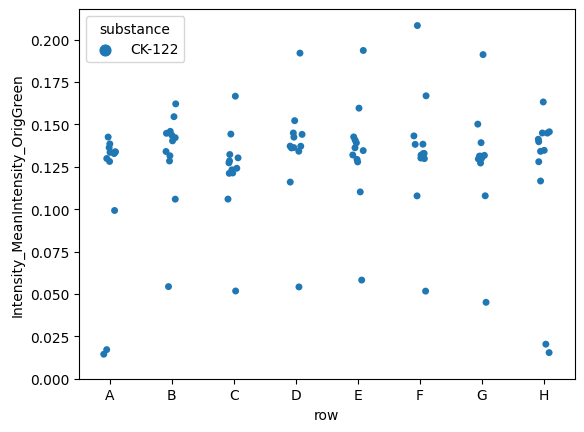

In [286]:
ax = sns.stripplot(data=data_extracted, x="row", y="Intensity_MeanIntensity_OrigGreen", hue = 'substance')
# ax.set(xscale="symlog")
# ax.set(xlim=(-1, 110))

ax.set(ylim = (0,None))
plt.show()



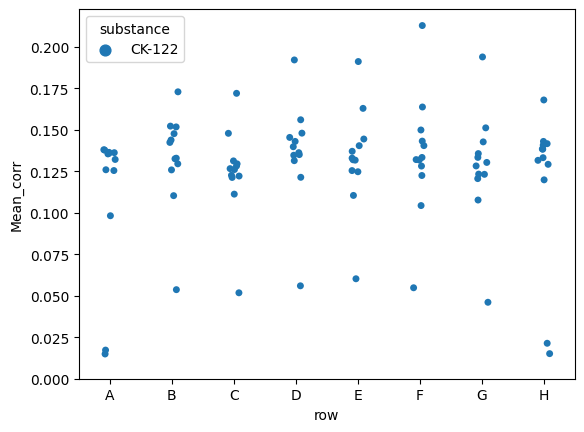

In [287]:
ax = sns.stripplot(data=data_extracted, x="row", y="Mean_corr", hue = 'substance')
# ax.set(xscale="symlog")
# ax.set(xlim=(-1, 110))

ax.set(ylim = (0,None))
plt.show()
